# Self-supervised Learning for microsleep detection

Authors: Sindri Jónsson 

Adapted from https://braindecode.org/stable/auto_examples/plot_relative_positioning.html#id5


In [14]:
# Initiliaze 

random_state = 87
n_jobs = 1

## Setup
1. Load datasets
2. Pre-process and windowing
3. Split data into train, validation and test sets
 

### Load datasets

In [15]:
# Load dataset 

import mne
import glob
from braindecode.datasets import BaseDataset, BaseConcatDataset
from IPython.display import clear_output

ds = []

channel_combs = [
    ("O1-M2", "E1-M1"),
    ("O1-M2", "E2-M1"),
    ("O2-M1", "E1-M1"),
    ("O2-M1", "E2-M1")
                ]

for path in glob.glob("SSL_data/*.edf"):

    for ch in channel_combs:

        # Read edf and add annotations
        file=mne.io.read_raw_edf(path)
    
        # Create one dataset for each channel combination (averaged across channel combinations in test predictions)
        drop_channels = [x for x in file.ch_names if x not in ch]
        file.drop_channels(drop_channels)
        
        subj = path.split("\\")[-1].replace(".edf","")
        ch_names = "_".join(ch)
        ds.append(BaseDataset(file, description={"subject": subj+"@"+ch_names}))
        clear_output()
        
    
ds = BaseConcatDataset(ds)

### Pre-process (re-sample)

In [16]:
# Pre-process signals: resample to 100 Hz
from braindecode.preprocessing.preprocess import preprocess, Preprocessor

# #Pre process data
signal_samp_freq = 100
pp = [Preprocessor("resample", sfreq=signal_samp_freq)]

preprocess(ds, pp) 


### Windowing

In [17]:
# Create window dataset

print("creating windows")

from braindecode.preprocessing import create_fixed_length_windows

# Extract windows
win_sec = 15       # Window length (sec)
step_sec = 1       # Step size (sec)
win_samp = int(win_sec * signal_samp_freq)
step_samp = int(step_sec * signal_samp_freq)


windows_dataset = create_fixed_length_windows(ds, window_size_samples=win_samp, window_stride_samples=step_samp,
                                  drop_last_window=True, preload=True)

creating windows


In [18]:
# Add target labels (MS) to window datset
from scipy.io import loadmat
import numpy as np

for w in windows_dataset.datasets:
    filename = f"edf_data/{w.description['subject']}_new.mat"
    filename = filename.replace("SSL_data","")
    filename = filename.split("@")[0] + "_new.mat"
    mat = loadmat(filename, squeeze_me=True)
    y = mat['x']
    y[np.isnan(y)] = -1
    w.y = y
    w.windows.metadata["target"] = w.y

### Pre-process (standardize)

In [19]:
# Pre-process windows: standardize windows channel-wise
from sklearn.preprocessing import scale as standard_scale
print("Pre-processing")
preprocess(windows_dataset, [Preprocessor(standard_scale, channel_wise=True)])

Pre-processing


### Split data

In [20]:
# Split the data to train, validation and test splits
import json
from braindecode.datasets import BaseConcatDataset

with open("splits/skorucack_splits_with_validation.json") as f:
    splits = json.load(f)


# Splitting dataset into train, valid and test sets
subj_train = splits['train']
subj_valid = splits["valid"]
subj_test = splits["test"]

class RelativePositioningDataset(BaseConcatDataset):
    """BaseConcatDataset with __getitem__ that expects 2 indices and a target.
    """
    def __init__(self, list_of_ds):
        super().__init__(list_of_ds)
        self.return_pair = True

    def __getitem__(self, index):
        if self.return_pair:
            ind1, ind2, y = index
            return (super().__getitem__(ind1)[0],
                    super().__getitem__(ind2)[0]), y
        else:
            return super().__getitem__(index)

    @property
    def return_pair(self):
        return self._return_pair

    @return_pair.setter
    def return_pair(self, value):
        self._return_pair = value



split_ids = {'train': subj_train, 'valid': subj_valid, 'test': subj_test}
splitted = dict()
for name, values in split_ids.items():
    splitted[name] = RelativePositioningDataset(
        [ds for ds in windows_dataset.datasets
        if ds.description['subject'].split("@")[0] in values])

## Pretext Task - Relative Positioning (RP)
1. Create RP samplers
2. Create and train embedder model
3. Plot training curves
4. Test embedder on RP task

### Create samplers

In [21]:
# Create samplers for relative positioning task

from braindecode.samplers import RelativePositioningSampler
n = 1200
tau_pos = int(signal_samp_freq * 15)
tau_neg = int(signal_samp_freq * 1 * 60)

n_examples_train = n * len(splitted['train'].datasets)
n_examples_valid = n * len(splitted['valid'].datasets)
n_examples_test = n * len(splitted['test'].datasets)

train_sampler = RelativePositioningSampler(
    splitted['train'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_train, same_rec_neg=True, random_state=random_state)
valid_sampler = RelativePositioningSampler(
    splitted['valid'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_valid, same_rec_neg=True,
    random_state=random_state).presample()
test_sampler = RelativePositioningSampler(
    splitted['test'].get_metadata(), tau_pos=tau_pos, tau_neg=tau_neg,
    n_examples=n_examples_test, same_rec_neg=True,
    random_state=random_state).presample()

### Create and train embedder

In [22]:
# Create model for RP task
import torch
from torch import nn
from braindecode.util import set_random_seeds
from braindecode.models import SleepStagerChambon2018

# Creating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
set_random_seeds(seed=random_state, cuda=device == 'cuda')

# Extract number of channels and time steps from dataset
n_channels, input_size_samples = windows_dataset[0][0].shape
emb_size = 100
tcs = 0.25

emb = SleepStagerChambon2018(
    n_channels,
    signal_samp_freq,
    n_classes=emb_size,
    n_conv_chs=16,
    time_conv_size_s=tcs,
    max_pool_size_s=tcs/4,
    input_size_s=input_size_samples / signal_samp_freq,
    dropout=0,
    pad_size_s=tcs,
    apply_batch_norm=True
)


class ContrastiveNet(nn.Module):
    """Contrastive module with linear layer on top of siamese embedder.

    Parameters
    ----------
    emb : nn.Module
        Embedder architecture.
    emb_size : int
        Output size of the embedder.
    dropout : float
        Dropout rate applied to the linear layer of the contrastive module.
    """
    def __init__(self, emb, emb_size, dropout=0.5):
        super().__init__()
        self.emb = emb
        self.clf = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, 1)
        )

    def forward(self, x):
        x1, x2 = x
        z1, z2 = self.emb(x1), self.emb(x2)
        return self.clf(torch.abs(z1 - z2)).flatten()


model = ContrastiveNet(emb, emb_size, dropout=0.5).to(device)

In [24]:
# Train RP model

import os
from datetime import date
from skorch.helper import predefined_split
from skorch.callbacks import Checkpoint, EarlyStopping, EpochScoring
from braindecode import EEGClassifier

lr = 5e-3
batch_size = 256  # 512 if data large enough
n_epochs = 50
num_workers = 0 if n_jobs <= 1 else n_jobs

cp = Checkpoint(dirname='', f_criterion=None, f_optimizer=None, f_history=None)
early_stopping = EarlyStopping(patience=10)
train_acc = EpochScoring(
    scoring='accuracy', on_train=True, name='train_acc', lower_is_better=False)
valid_acc = EpochScoring(
    scoring='accuracy', on_train=False, name='valid_acc',
    lower_is_better=False)
callbacks = [
    ('cp', cp),
    ('patience', early_stopping),
    ('train_acc', train_acc),
    ('valid_acc', valid_acc)
]

clf = EEGClassifier(
    model,
    criterion=torch.nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    max_epochs=n_epochs,
    iterator_train__shuffle=False,
    iterator_train__sampler=train_sampler,
    iterator_valid__sampler=valid_sampler,
    iterator_train__num_workers=num_workers,
    iterator_valid__num_workers=num_workers,
    train_split=predefined_split(splitted['valid']),
    optimizer__lr=lr,
    batch_size=batch_size,
    callbacks=callbacks,
    device=device
)


train_model = False
 
if train_model:
    today = date.today().strftime("%d%m%Y")
    folder = f"SSL_{today}"
    os.mkdir(folder)
# Model training for a specified number of epochs. `y` is None as it is already
# supplied in the dataset.
    clf.fit(splitted['train'], y=None)
    clf.load_params(checkpoint=cp)  # Load the model with the lowest valid_loss
    clf.save_params(f_params=f"{folder}\\model.pkl",
        f_optimizer=f"{folder}\\optimizer.pkl",
        f_history=f"{folder}\\history.json")
    os.remove("params.pt")
else:
    # Load
    load_folder = "SSL_16022023"
    clf.initialize()
    clf.load_params(f_params=f"{load_folder}\\model.pkl",
            f_optimizer=f"{load_folder}\\optimizer.pkl",
            f_history=f"{load_folder}\\history.json")


### Plot training curves

C:\Users\SIOS\AppData\Local\Temp\ipykernel_38660\31475270.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


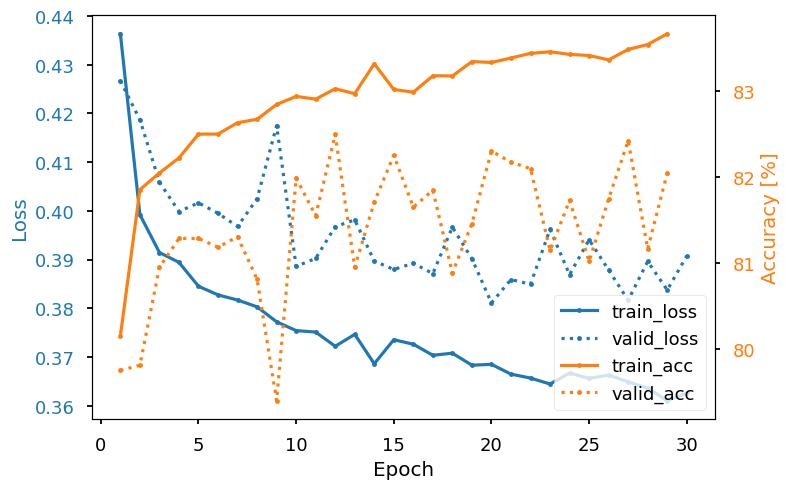

In [25]:
# Plot RP training curves


import matplotlib.pyplot as plt
import pandas as pd

# Extract loss and balanced accuracy values for plotting from history object
df = pd.DataFrame(clf.history.to_list())

df['train_acc'] *= 100
df['valid_acc'] *= 100

ys1 = ['train_loss', 'valid_loss']
ys2 = ['train_acc', 'valid_acc']
styles = ['-', ':']
markers = ['.', '.']

plt.style.use('seaborn-talk')

fig, ax1 = plt.subplots(figsize=(8, 5))
ax2 = ax1.twinx()
for y1, y2, style, marker in zip(ys1, ys2, styles, markers):
    ax1.plot(df['epoch'], df[y1], ls=style, marker=marker, ms=7,
             c='tab:blue', label=y1)
    ax2.plot(df['epoch'], df[y2], ls=style, marker=marker, ms=7,
             c='tab:orange', label=y2)

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylabel('Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_ylabel('Accuracy [%]', color='tab:orange')
ax1.set_xlabel('Epoch')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2)

plt.tight_layout()
plt.show()

### Test results in RP task

In [26]:
# Test results of RP task
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Switch to the test sampler
clf.iterator_valid__sampler = test_sampler
y_pred = clf.forward(splitted['test'], training=False) > 0
y_true = [y for _, _, y in test_sampler]

print("RP test data")
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

RP test data
[[47154  8016]
 [ 9979 45251]]
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84     55170
         1.0       0.85      0.82      0.83     55230

    accuracy                           0.84    110400
   macro avg       0.84      0.84      0.84    110400
weighted avg       0.84      0.84      0.84    110400



## Downstream task
1. Generate features using embedder
2. Train logistic regression classifier (channel wise)
3. Optimal thresholding
4. Test predictions

### Generate features using embedder

In [27]:
# Generate features from the embedder for the train, validation and test splits
from torch.utils.data import DataLoader

# Extract features with the trained embedder
data = dict()
for name, split in splitted.items():
    print(name)
    split.return_pair = False  # Return single windows
    loader = DataLoader(split, batch_size=batch_size, num_workers=num_workers)
    i = 0
    with torch.no_grad():
        feats = []
        for batch_x, _, _ in loader:
            f=emb(batch_x.to(device)).cpu().numpy()
            feats.append(f)
            prc = i/(len(loader)-1)*100
            print(f"{name}: {prc:.2f}%", flush=True)
            i += 1
    data[name] = (np.concatenate(feats), split.get_metadata()['target'].values)


train
train: 0.00%
train: 0.07%
train: 0.14%
train: 0.21%
train: 0.29%
train: 0.36%
train: 0.43%
train: 0.50%
train: 0.57%
train: 0.64%
train: 0.71%
train: 0.79%
train: 0.86%
train: 0.93%
train: 1.00%
train: 1.07%
train: 1.14%
train: 1.21%
train: 1.29%
train: 1.36%
train: 1.43%
train: 1.50%
train: 1.57%
train: 1.64%
train: 1.71%
train: 1.79%
train: 1.86%
train: 1.93%
train: 2.00%
train: 2.07%
train: 2.14%
train: 2.21%
train: 2.29%
train: 2.36%
train: 2.43%
train: 2.50%
train: 2.57%
train: 2.64%
train: 2.71%
train: 2.79%
train: 2.86%
train: 2.93%
train: 3.00%
train: 3.07%
train: 3.14%
train: 3.21%
train: 3.29%
train: 3.36%
train: 3.43%
train: 3.50%
train: 3.57%
train: 3.64%
train: 3.71%
train: 3.79%
train: 3.86%
train: 3.93%
train: 4.00%
train: 4.07%
train: 4.14%
train: 4.21%
train: 4.29%
train: 4.36%
train: 4.43%
train: 4.50%
train: 4.57%
train: 4.64%
train: 4.71%
train: 4.79%
train: 4.86%
train: 4.93%
train: 5.00%
train: 5.07%
train: 5.14%
train: 5.21%
train: 5.29%
train: 5.36%
train:

### Train logistic regression classifier using features

In [28]:
# Train logistic regression model to classify wake vs MS using features from embedder

from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


# Initialize the logistic regression model
log_reg = LogisticRegression(
    penalty='l2', C=1.0, class_weight='balanced', solver='lbfgs',
    multi_class='auto', random_state=random_state, max_iter=1000)
 
clf_pipe = make_pipeline(StandardScaler(), log_reg)
 
# Make sure that all data is [-1,1]
data['train'][1][data['train'][1] == 0] = -1
data['valid'][1][data['valid'][1] == 0] = -1
data['test'][1][data['test'][1] == 0] = -1 
  
# Fit and score the logistic regression
clf_pipe.fit(*data['train'])
train_y_pred = clf_pipe.predict(data['train'][0])
valid_y_pred = clf_pipe.predict(data['valid'][0])
test_y_pred = clf_pipe.predict(data['test'][0])
 
train_bal_acc = balanced_accuracy_score(data['train'][1], train_y_pred)
valid_bal_acc = balanced_accuracy_score(data['valid'][1], valid_y_pred)
 
print('Sleep staging performance with logistic regression:')
print(f'Train bal acc: {train_bal_acc:0.4f}')
print(f'Valid bal acc: {valid_bal_acc:0.4f}')
 
print('Results on validation set:')
print(confusion_matrix(data['valid'][1], valid_y_pred))
print(classification_report(data['valid'][1], valid_y_pred))

Sleep staging performance with logistic regression:
Train bal acc: 0.8817
Valid bal acc: 0.9170
Results on validation set:
[[85028  9712]
 [  582  8598]]
              precision    recall  f1-score   support

        -1.0       0.99      0.90      0.94     94740
         1.0       0.47      0.94      0.63      9180

    accuracy                           0.90    103920
   macro avg       0.73      0.92      0.78    103920
weighted avg       0.95      0.90      0.91    103920



### Find optimal threshold 

In [29]:
# Find optimal thresholding using averaged validation probabilities

# Collect averaged probability data per subject for all channel combinations
val_data = {d.description['subject'].split("@")[0]: {"probs": [], "y": []} 
                for d in windows_dataset.datasets
                     if d.description['subject'].split("@")[0] in split_ids['valid']}
 
for d in windows_dataset.datasets:
    id = d.description['subject'].split("@")[0]
 
    if id not in split_ids['valid']:
        continue
 
    print(d.description['subject'])
    window_data = d.windows.get_data()
    features = emb(torch.Tensor(window_data)).detach().numpy()
    probs = clf_pipe.predict_proba(features)
    val_data[id]["probs"].append(probs)
    val_data[id]["y"] = d.y

# Average probabilites
for k, v in val_data.items():
    all_probs = np.array(v["probs"]).mean(axis=0)[:,1]
    val_data[k]["avg_probs"] = all_probs

 
valid_probs = np.concatenate([v["avg_probs"] for _, v in val_data.items()])
valid_y = np.concatenate([v["y"] for _, v in val_data.items()]) > 0
 

9098@O1-M2_E1-M1
9098@O1-M2_E2-M1
9098@O2-M1_E1-M1
9098@O2-M1_E2-M1
Af8a@O1-M2_E1-M1
Af8a@O1-M2_E2-M1
Af8a@O2-M1_E1-M1
Af8a@O2-M1_E2-M1
AsLD@O1-M2_E1-M1
AsLD@O1-M2_E2-M1
AsLD@O2-M1_E1-M1
AsLD@O2-M1_E2-M1
Dr51@O1-M2_E1-M1
Dr51@O1-M2_E2-M1
Dr51@O2-M1_E1-M1
Dr51@O2-M1_E2-M1
DYYI@O1-M2_E1-M1
DYYI@O1-M2_E2-M1
DYYI@O2-M1_E1-M1
DYYI@O2-M1_E2-M1
fT68@O1-M2_E1-M1
fT68@O1-M2_E2-M1
fT68@O2-M1_E1-M1
fT68@O2-M1_E2-M1
MS6u@O1-M2_E1-M1
MS6u@O1-M2_E2-M1
MS6u@O2-M1_E1-M1
MS6u@O2-M1_E2-M1
Msy4@O1-M2_E1-M1
Msy4@O1-M2_E2-M1
Msy4@O2-M1_E1-M1
Msy4@O2-M1_E2-M1
SOZ3@O1-M2_E1-M1
SOZ3@O1-M2_E2-M1
SOZ3@O2-M1_E1-M1
SOZ3@O2-M1_E2-M1
Y4FK@O1-M2_E1-M1
Y4FK@O1-M2_E2-M1
Y4FK@O2-M1_E1-M1
Y4FK@O2-M1_E2-M1
YHLr@O1-M2_E1-M1
YHLr@O1-M2_E2-M1
YHLr@O2-M1_E1-M1
YHLr@O2-M1_E2-M1


In [ ]:
valid_probs

In [38]:

# pr curve for logistic regression model
from sklearn.metrics import precision_score, recall_score

valid_probs = [v["avg_probs"] for _, v in test_data.items()]
valid_y = test_y

# calculate pr-curve
thresholds = np.arange(start=0.025, stop=1.0, step=0.025)
precision = np.array([precision_score(valid_y, valid_probs>=t) for t in thresholds])
recall = np.array([recall_score(valid_y, valid_probs>=t) for t in thresholds])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
opt_idx = np.argmax(fscore)

# plot the roc curve for the model
no_skill = len(valid_y[valid_y==1]) / len(valid_y)
_, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
ax1.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="tab:orange")
ax1.plot(recall, precision, marker='.', label='mU-Sleep', color="tab:blue")
ax1.plot(recall[opt_idx], precision[opt_idx], marker="*", color="tab:green", markersize=12, label="Optimal", linestyle="none")
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.legend()
ax1.grid()
info_txt = f"Threshold={thresholds[opt_idx]:.2f}\nF1-Score={fscore[opt_idx]:.2f}" 
ty = -0.1
tx = -0.25
ax1.text(recall[opt_idx]+tx, precision[opt_idx]+ty, info_txt)

# Plot F1-threshold curve
ax2.plot(thresholds, fscore, marker='.', color="tab:blue")
ax2.plot(thresholds[opt_idx], fscore[opt_idx], marker='*', markersize=12, color="tab:green", label="Optimal")
ax2.set_ylim([0,1])
ax2.grid()
ax2.set_xlabel("Thresholds")
ax2.set_ylabel("F1-Score")

print('Best Threshold=%.3f, F-Score=%.3f, Recall=%.3f, Precision=%.3f' % (thresholds[opt_idx], fscore[opt_idx], recall[opt_idx], precision[opt_idx]))


C:\Users\SIOS\AppData\Local\Temp\ipykernel_38660\1586499225.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  precision = np.array([precision_score(valid_y, valid_probs>=t) for t in thresholds])


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Test predictions 

In [39]:
# Make test predictions using average probabilites per subject across channel combinations using optimal index

# Collect data

test_data = {d.description['subject'].split("@")[0]: {"probs": [], "y": []} 
                for d in windows_dataset.datasets
                     if d.description['subject'].split("@")[0] in split_ids['test']}
 
for d in windows_dataset.datasets:
    id = d.description['subject'].split("@")[0]
 
    if id not in split_ids['test']:
        continue
 
    print(d.description['subject'])
    window_data = d.windows.get_data()
    features = emb(torch.Tensor(window_data)).detach().numpy()
    probs = clf_pipe.predict_proba(features)
    test_data[id]["probs"].append(probs)
    test_data[id]["y"] = d.y
 
for k, v in test_data.items():
    all_probs = np.array(v["probs"]).mean(axis=0)[:,1]
    test_data[k]["avg_probs"] = all_probs
 
from sklearn.metrics import cohen_kappa_score, f1_score
 
test_preds = np.concatenate([v["avg_probs"] for _, v in test_data.items()]) >= thresholds[opt_idx]
test_y = np.concatenate([v["y"] for _, v in test_data.items()]) > 0
 
print(f"Logistic regression Cohen's kappa (@ {thresholds[opt_idx]:.2f}) with averaged probabilites:")
print(cohen_kappa_score(test_y, test_preds))
 
print(f"Logistic regression F1 score (@ {thresholds[opt_idx]:.2f}) with averaged probabilites:")
print(f1_score(test_y, test_preds))

0pai@O1-M2_E1-M1
0pai@O1-M2_E2-M1
0pai@O2-M1_E1-M1
0pai@O2-M1_E2-M1
3P0D@O1-M2_E1-M1
3P0D@O1-M2_E2-M1
3P0D@O2-M1_E1-M1
3P0D@O2-M1_E2-M1
40kO@O1-M2_E1-M1
40kO@O1-M2_E2-M1
40kO@O2-M1_E1-M1
40kO@O2-M1_E2-M1
6iwd@O1-M2_E1-M1
6iwd@O1-M2_E2-M1
6iwd@O2-M1_E1-M1
6iwd@O2-M1_E2-M1
6JVj@O1-M2_E1-M1
6JVj@O1-M2_E2-M1
6JVj@O2-M1_E1-M1
6JVj@O2-M1_E2-M1
BSvO@O1-M2_E1-M1
BSvO@O1-M2_E2-M1
BSvO@O2-M1_E1-M1
BSvO@O2-M1_E2-M1
csxQ@O1-M2_E1-M1
csxQ@O1-M2_E2-M1
csxQ@O2-M1_E1-M1
csxQ@O2-M1_E2-M1
DSfb@O1-M2_E1-M1
DSfb@O1-M2_E2-M1
DSfb@O2-M1_E1-M1
DSfb@O2-M1_E2-M1
EyTS@O1-M2_E1-M1
EyTS@O1-M2_E2-M1
EyTS@O2-M1_E1-M1
EyTS@O2-M1_E2-M1
hcml@O1-M2_E1-M1
hcml@O1-M2_E2-M1
hcml@O2-M1_E1-M1
hcml@O2-M1_E2-M1
hRMy@O1-M2_E1-M1
hRMy@O1-M2_E2-M1
hRMy@O2-M1_E1-M1
hRMy@O2-M1_E2-M1
ibbz@O1-M2_E1-M1
ibbz@O1-M2_E2-M1
ibbz@O2-M1_E1-M1
ibbz@O2-M1_E2-M1
IhpU@O1-M2_E1-M1
IhpU@O1-M2_E2-M1
IhpU@O2-M1_E1-M1
IhpU@O2-M1_E2-M1
kj2l@O1-M2_E1-M1
kj2l@O1-M2_E2-M1
kj2l@O2-M1_E1-M1
kj2l@O2-M1_E2-M1
Kn9O@O1-M2_E1-M1
Kn9O@O1-M2_E2-M1
Kn9O@O2-M1_E1-

### Plotting feature space (PCA)

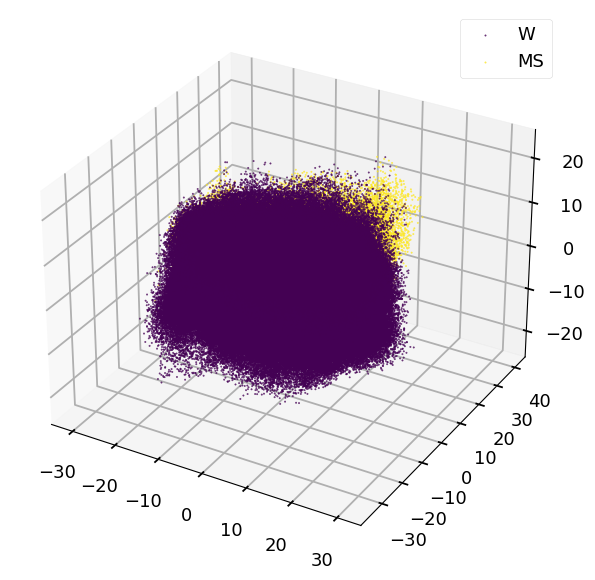

In [35]:
# Feature space PCA plot

# get_ipython().run_line_magic('matplotlib', 'widget')
from sklearn.decomposition import PCA
from matplotlib import cm
 
X = np.concatenate([v[0] for k, v in data.items()])
y = np.concatenate([v[1] for k, v in data.items()])
y[y!=1] = 0
 
n = 3
 
pca = PCA(n_components=n)
#tsne = TSNE(n_components=n)
components = pca.fit_transform(X)
 
stages = ["W","MS"]
if n != 3:
    fig, ax = plt.subplots()
    colors = cm.get_cmap('viridis', 2)(range(2))
    for i, stage in enumerate(stages):
        mask = y == i
        ax.scatter(components[mask, 0], components[mask, 1], s=3, alpha=0.7,
                   color=colors[i], label=stage)
else:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    colors = cm.get_cmap('viridis', 2)(range(2))
    for i, stage in enumerate(stages):
        mask = y == i
        ax.scatter(components[mask, 0], components[mask, 1], components[mask, 2],
                   s=1, alpha=0.7, color=colors[i], label=stage)
 
ax.legend()
plt.show()

## Collect all data to export to matlab for analysis

### Training data

In [21]:

train_data = {d.description['subject'].split("@")[0]: {"probs": [], "y": []} 
                for d in windows_dataset.datasets
                     if d.description['subject'].split("@")[0] in split_ids['train']}
 
for d in windows_dataset.datasets:
    id = d.description['subject'].split("@")[0]
 
    if id not in split_ids['train']:
        continue
 
    print(d.description['subject'])
    window_data = d.windows.get_data()
    features = emb(torch.Tensor(window_data)).detach().numpy()
    probs = clf_pipe.predict_proba(features)
    train_data[id]["probs"].append(probs)
    train_data[id]["y"] = d.y
 
for k, v in train_data.items():
    all_probs = np.array(v["probs"]).mean(axis=0)[:,1]
    train_data[k]["avg_probs"] = all_probs



0ncr@O1-M2_E1-M1
0ncr@O1-M2_E2-M1
0ncr@O2-M1_E1-M1
0ncr@O2-M1_E2-M1
3J4W@O1-M2_E1-M1
3J4W@O1-M2_E2-M1
3J4W@O2-M1_E1-M1
3J4W@O2-M1_E2-M1
5bSg@O1-M2_E1-M1
5bSg@O1-M2_E2-M1
5bSg@O2-M1_E1-M1
5bSg@O2-M1_E2-M1
9JQY@O1-M2_E1-M1
9JQY@O1-M2_E2-M1
9JQY@O2-M1_E1-M1
9JQY@O2-M1_E2-M1
AXbm@O1-M2_E1-M1
AXbm@O1-M2_E2-M1
AXbm@O2-M1_E1-M1
AXbm@O2-M1_E2-M1
bkx9@O1-M2_E1-M1
bkx9@O1-M2_E2-M1
bkx9@O2-M1_E1-M1
bkx9@O2-M1_E2-M1
C1Wu@O1-M2_E1-M1
C1Wu@O1-M2_E2-M1
C1Wu@O2-M1_E1-M1
C1Wu@O2-M1_E2-M1
cblr@O1-M2_E1-M1
cblr@O1-M2_E2-M1
cblr@O2-M1_E1-M1
cblr@O2-M1_E2-M1
d3ET@O1-M2_E1-M1
d3ET@O1-M2_E2-M1
d3ET@O2-M1_E1-M1
d3ET@O2-M1_E2-M1
ddTG@O1-M2_E1-M1
ddTG@O1-M2_E2-M1
ddTG@O2-M1_E1-M1
ddTG@O2-M1_E2-M1
DjrT@O1-M2_E1-M1
DjrT@O1-M2_E2-M1
DjrT@O2-M1_E1-M1
DjrT@O2-M1_E2-M1
EHED@O1-M2_E1-M1
EHED@O1-M2_E2-M1
EHED@O2-M1_E1-M1
EHED@O2-M1_E2-M1
EMcQ@O1-M2_E1-M1
EMcQ@O1-M2_E2-M1
EMcQ@O2-M1_E1-M1
EMcQ@O2-M1_E2-M1
f8H5@O1-M2_E1-M1
f8H5@O1-M2_E2-M1
f8H5@O2-M1_E1-M1
f8H5@O2-M1_E2-M1
fNe4@O1-M2_E1-M1
fNe4@O1-M2_E2-M1
fNe4@O2-M1_E1-

### Collect validation and trian data as dev data

In [22]:
from scipy.io import savemat

dev_id = []
dev_probs = []
dev_true = []

for k, v in val_data.items():
    dev_id.append(k)
    dev_probs.append(v["avg_probs"])
    dev_true.append(v['y'])

for k, v in train_data.items():
    dev_id.append(k)
    dev_probs.append(v["avg_probs"])
    dev_true.append(v['y'])

dev_out = {"id": dev_id, 
           "probs": dev_probs,
           "yTrue": dev_true,
           "optThres": thresholds[opt_idx]}

savemat("Matlab/training_performance/ssl.mat", mdict = dev_out)

c:\Users\Sindri\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\io\matlab\_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


### Test data

In [23]:
test_id = []
test_probs = []
test_true = []

for k, v in test_data.items():
    test_id.append(k)
    test_probs.append(v["avg_probs"])
    test_true.append(v['y'])

test_out = {"id": test_id, 
           "probs": test_probs,
           "yTrue": test_true,
           "optThres": thresholds[opt_idx]}

savemat("Matlab/ssl.mat", mdict = test_out)
